# The Bridge Game

The glass bridge is a game in the [Netflix](https://netflix.com/) series [The Squid Game](https://www.imdb.com/title/tt10919420/). The series is Netflix's most-watched series to date, becoming the top-viewed program in 94 countries and attracting more than 142 million member households during its first four weeks from launch. (Source [Wikipedia](https://en.wikipedia.org/wiki/Squid_Game))

**Spoiler Alert** Don't read the article if you intend to watch the series!

![Squid Game Copyright Netflix 2021](squid_game_poster.png){: .center}

<p align="center">
<i><a href="https://www.netflix.com/de/title/81040344">Squid Game</a> - © Netflix 2021</i>
</p>


In one scene in Episode 7, 16 players have to cross a bridge made of two rows of glass tiles. The bridge is 18 steps long. They have to jump to one tile per row, but just one tile will last whereas the other one is made of tempered glass, which breaks under impact. The players start in an ordered fashion, whereby players with higher numbers will avoid broken tiles. To penalize players with higher numbers, there is a time-limit after which players who have not passed the bridge have lost as well (and pay with their lives).

**Disclaimer** The author considers the game purely from a scientific/fictional perspective. The game as well as  the concept of the series are immoral, wrong, and detestable.

![Squid Game Copyright Netflix 2021](squid_game_bridge_scene.png){: .center}

<p align="center">
<i><a href="https://www.netflix.com/de/title/81040344">Squid Game</a> - © Netflix 2021</i>
</p>


Inspired by another [simulation](https://www.jhelvy.com/posts/2021-10-19-monte-carlo-bridge-game/) this example illustrates how to run simulations in different configurations many times to work out process parameters. Here, the key parameter of interest is the **number of surviving players**.

As players in the show can pick their start number, the episode - as well as the internet community - circles around the question regarding an optimal start number to _optimize the chance of survival_.

## Model

To answer this question, we will model and analyze the process with `kalasim`. At its heart - which is its [process definition](../component.md#process-definition) -  it is a very simplistic model that centers around simulating the participant's stepping on the tiles one after another while considering the _learning experience_ of earlier participants with lower start numbers.


In [43]:
//@file:Repository("*mavenLocal")
//@file:DependsOn("com.github.holgerbrandl:kalasim:0.7-SNAPSHOT")

@file:DependsOn("com.github.holgerbrandl:kalasim:0.6.92")
@file:DependsOn("com.github.holgerbrandl:kravis:0.8.1")

In [44]:
import org.kalasim.*

import kravis.geomBar
import kravis.geomCol
import kravis.plot
import org.apache.commons.math3.distribution.LogNormalDistribution

import java.lang.Double.min
import kotlin.random.Random

In [45]:
//LogNormalDistribution(3.5, 0.88).let{ dist ->
//    repeat(100){ println(dist.sample())}
//}

//TODO set random seed, blocked by https://github.com/Kotlin/kotlin-jupyter/issues/345


In [86]:
class SquidGame(
    val numSteps: Int = 18,
    val numPlayers: Int = 16,
    val maxDuration: Int = 12 * 60
) : Environment(randomSeed =Random.nextInt()) {

    // randomization
    val stepTime = LogNormalDistribution(rg, 3.0, 0.88)
//    val stepTime = uniform(10,30)

    val decision = enumerated(true, false)

    // state
    var stepsLeft = numSteps
    var survivors= mutableListOf<Int>()

    val numTrials: Int
        get() = numSteps - survivors.size

    val numSurvivors : Int
       get() = survivors.size

    fun playerSurvived(playerNo: Int) = survivors.contains(playerNo)

    init {
        object : Component() {
            override fun process() = sequence {
               queue@
               for(player in 1..numPlayers){
                    hold(min(stepTime(), 100.0)) // cap time at 100sec

                    while(stepsLeft-- > 0){
                        if(decision()) continue@queue
                        hold(min(stepTime(), 100.0)) // cap time at 100sec
                    }

                    if(now > maxDuration) break

                    survivors.add(player)
                }
            }
        }
    }
}

Move times are modeled using a log-normal distribution with the parameters from [here](https://www.jhelvy.com/posts/2021-10-19-monte-carlo-bridge-game/). Similar to the previous work, we cap the time it takes a player to make a move (or just part of it) at 100 seconds.

To get started, we can simply run the simulation with

In [87]:
val sim = SquidGame()
sim.run()

println("${sim.numSurvivors} survived")

5 survived


In [88]:
sim.playerSurvived(13)

true

In [89]:
(1..18).map{ sim.playerSurvived(it)}

[false, false, false, false, false, false, false, false, false, false, false, true, true, true, true, true, false, false]

The model seems fine at first glance. In particular, the impact of timing becomes visible, as the last player did not survive the game

Some players survived the game. But clearly, running it once does not tell much about the average number of survivors. So we run it many times and visualize the distribution.


In [90]:
val manyGames = org.kalasim.misc.repeat(10000) {
    SquidGame().apply { run() }
}

val avgSurvivors = manyGames.map { it.numSurvivors }.average()
println("The average number of survivors is ${avgSurvivors}")

The average number of survivors is 5.436


Now since we have sampled the process, we can also easily visualize the survival count distribution

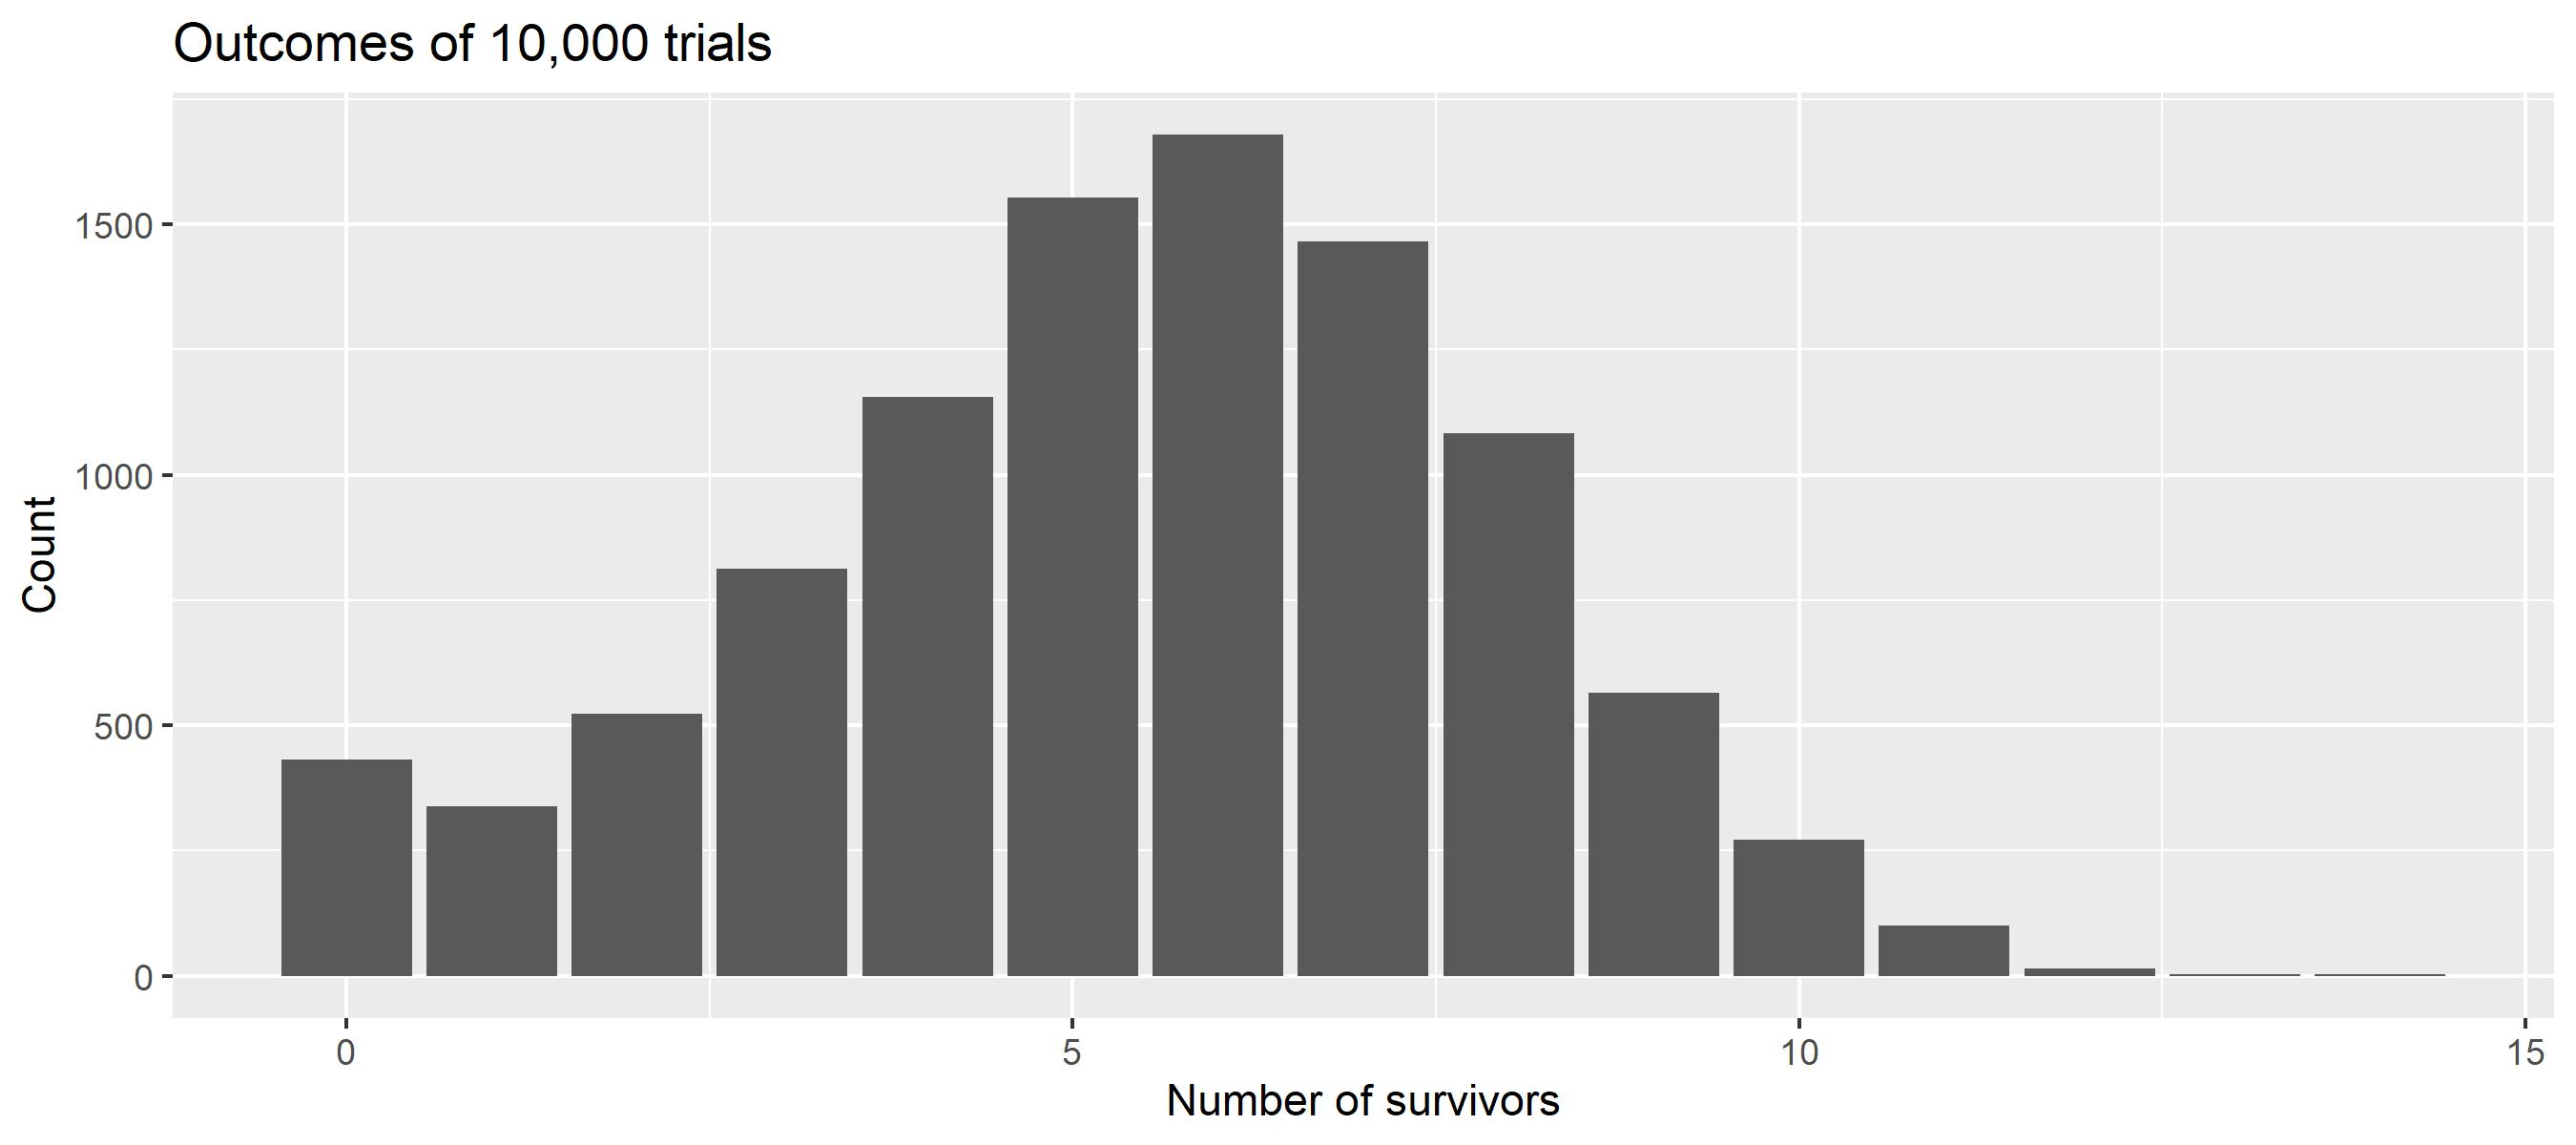

In [91]:
manyGames.plot(x = { numSurvivors }).geomBar().labs(
    title = "Outcomes of 10,000 trials",
    x = "Number of survivors",
    y = "Count"
)


As we learn from the plot, we have obtained predominantly uni-modal distribution with an average of around 6 and minor zero-inflation. So on average 6 players will survive the game.

## Maximize Survival

To better understand the process, we want to visualize the probability of survival based on the player order number.

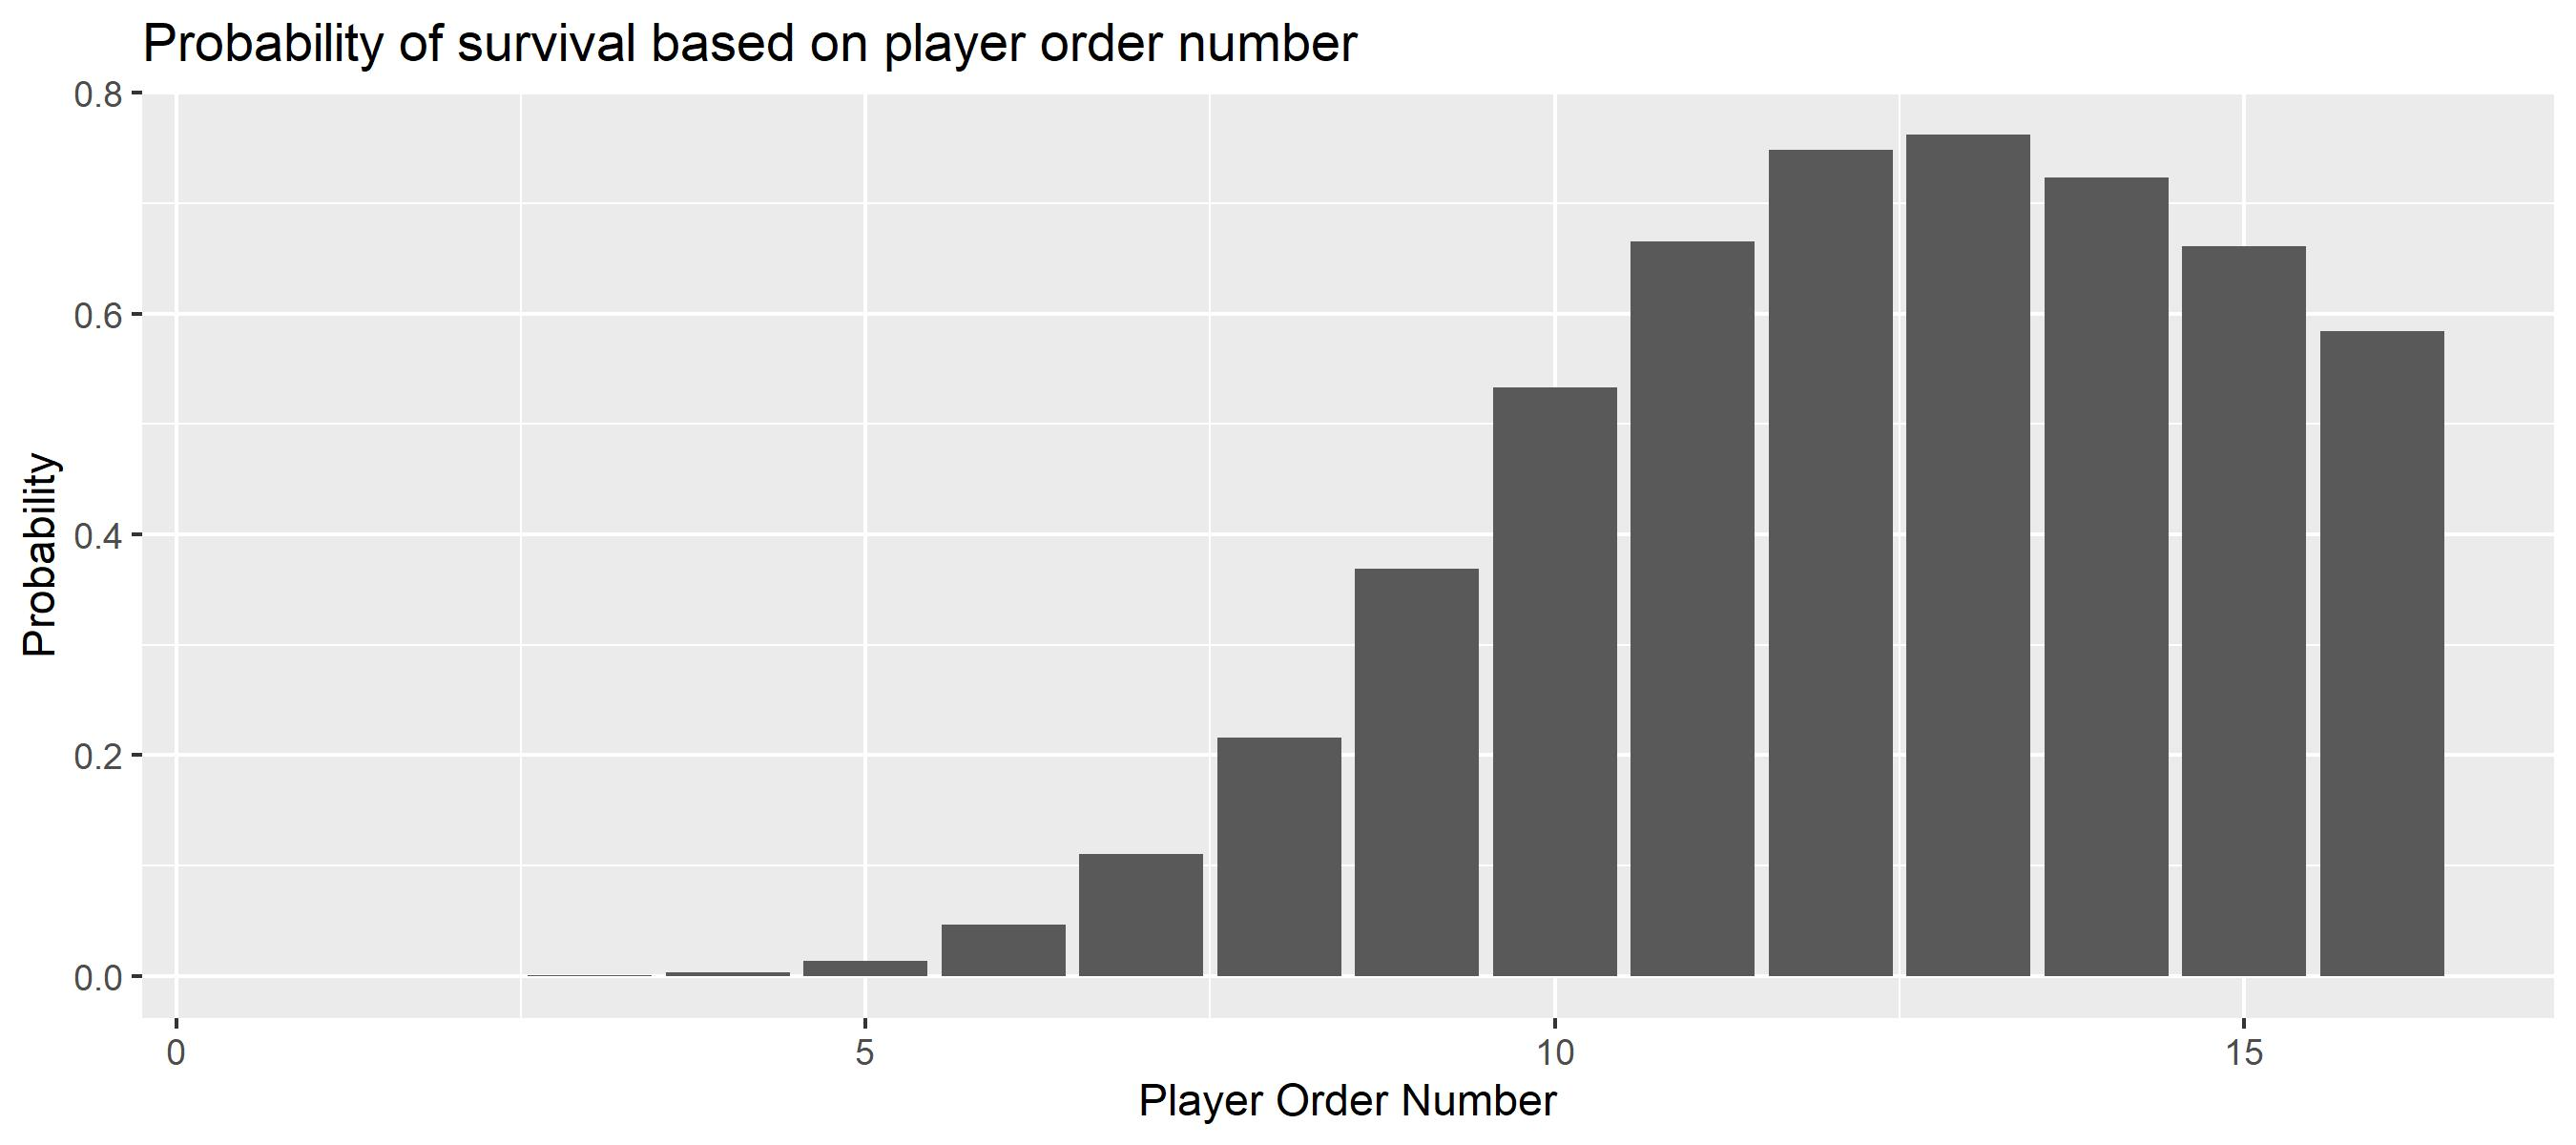

In [92]:
val survivalProbByNo = (1..manyGames.first().numPlayers).map { playerNo ->
    playerNo to manyGames.count { it.playerSurvived(playerNo) }.toDouble() / manyGames.size
}

survivalProbByNo.plot(x = { it.first }, y = { it.second }).geomCol().labs(
    title = "Probability of survival based on player order number",
    x = "Player Order Number",
    y = "Probability"
)

So indeed there seems a strategy to maximize your odds of survival in the game. Simply pick **No13**, and you may live more likely compared to any other starting number.


## Game Continuation

Now, we calculate the probability of having less than two survivors. That's in particular relevant in the series, as the bridge game is not meant to be the last game, and at least 2 players are required to continue the games.


In [93]:
val probLT2Players = manyGames.count { it.numSurvivors < 2 }.toDouble() / manyGames.size
println("the probability for less than 2 players is ${probLT2Players}")


the probability for less than 2 players is 0.0771
On average 5.436 players will survive the game of squid


One may wonder why the makers of the series have placed 18 steps and not more or less. What do the numbers say? What are the odds for game continuation (# survivors >2) when the number of steps is different?

To answer these questions, let's re-run the model while varying the steps. To keep things simple, we run 10,000 iterations of the game over an increasing number of steps from 10 to 30:


In [94]:
val stepSims = (10..30).flatMap { numSteps ->
    org.kalasim.misc.repeat(10000) {
        SquidGame(numSteps = numSteps).apply { run() }
    }
}

val stepSimSummary = stepSims.groupBy { it.numSteps }.map { (steps, games) ->
    steps to games.count { it.numSurvivors < 2 }.toDouble() / games.size
}

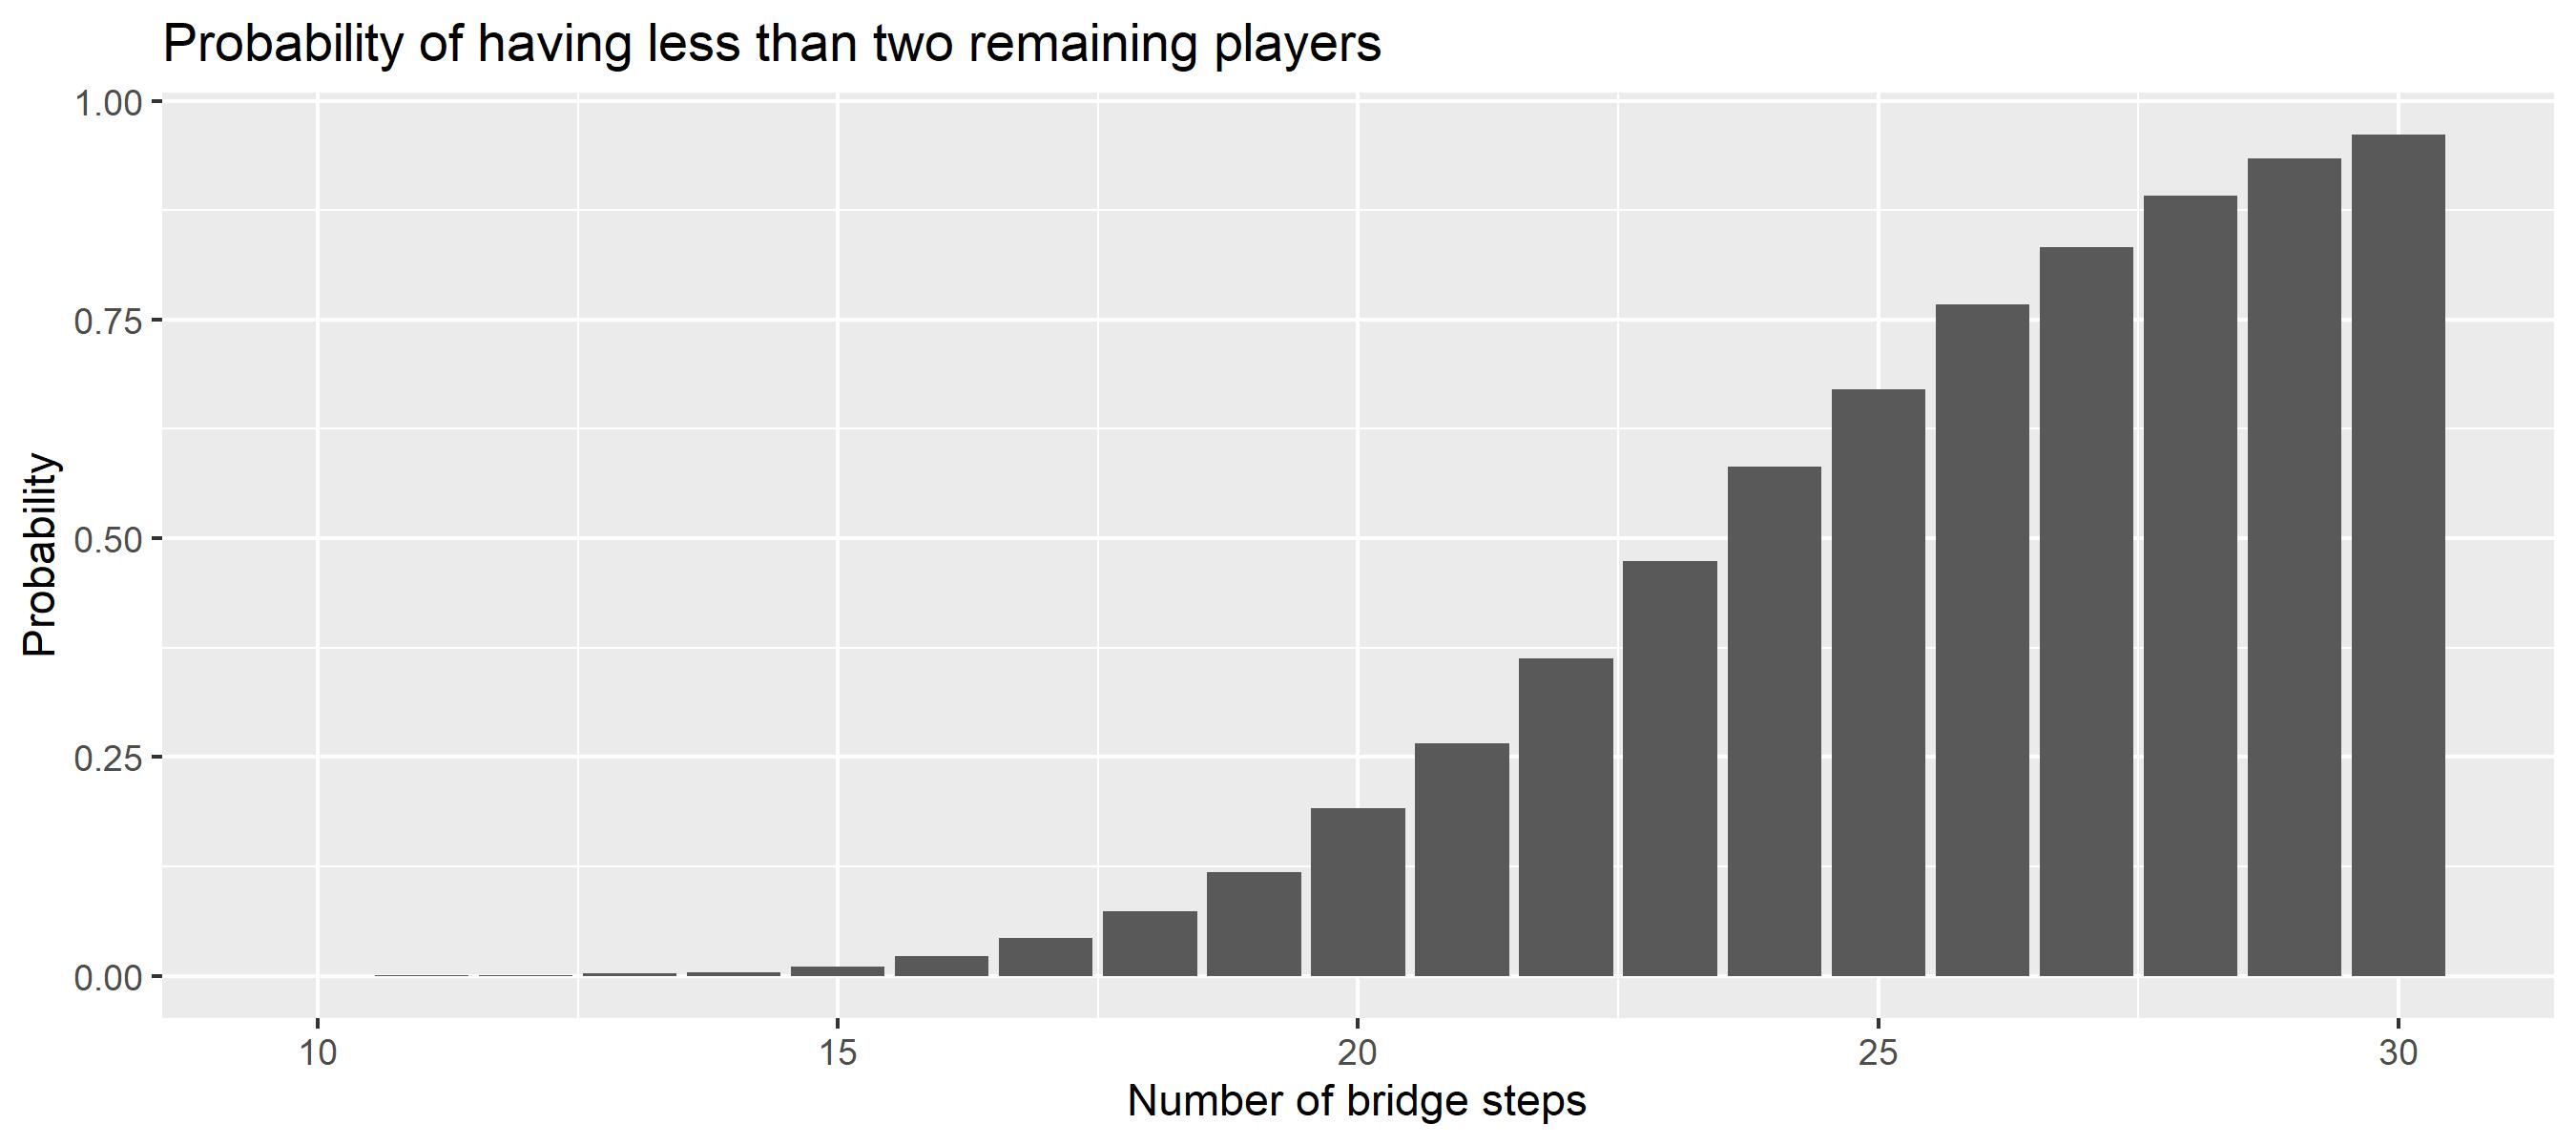

In [95]:
stepSimSummary.plot(x = { it.first }, y = { it.second }).geomCol().labs(
    title = "Probability of having less than two remaining players",
    x = "Number of bridge steps",
    y = "Probability"
)

With more than 16 steps, the odds of having more than 2 players decay quickly.

## Conclusion

In this example we have explored a simple generative model. By means of simulation we have worked out an optimal strategy to survive the bridge game. But be reminded, if you ever find an invite to a squid-like game on your doorstep in times of despair , trash it, smoke it or eat it. There are better - and more fun - ways to make money, such as optimizing real-world processes with simulation and business intelligence.

For complete sources, also see the jupyter [notebook](https://nbviewer.org/github/holgerbrandl/kalasim/blob/master/docs/userguide/docs/examples/bridge_game.ipynb). Feel welcome to [get in touch](../index.md#support) for support, suggestions, and questions.